In [67]:
! pip install -Uq langgraph langchain-google-genai

In [68]:
from langgraph.graph import START,END,StateGraph
from IPython.display import display,Image
from langgraph.graph.state import CompiledStateGraph
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
from typing import Annotated
from operator import add

In [69]:
class OverallState(TypedDict):
    paragraph:Annotated[str,add]
    feedback:str
    rating :str
    sentiment:str
    correction:str

In [70]:
class CorrectionAndFeedbackState(TypedDict):
    paragraph:Annotated[str,add]
    correction:str
    feedback:str

class RatingAndSentimentState(TypedDict):
    paragraph:Annotated[str,add]
    rating:str
    sentiment:str

In [71]:
load_dotenv()
api_key = os.getenv('GEMINI_API_KEY')

llm:ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=api_key)
# llm.invoke("Hello")

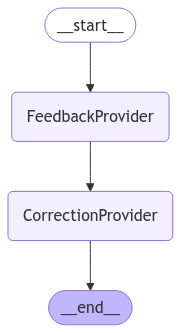

In [72]:
def feedback_node(state:CorrectionAndFeedbackState):
    ''' This function is responsible for giving a feedback to the user on the pargraph he wrote'''
    paragraph = state['paragraph'] 
    prompt = f'This is the paragraph: {paragraph} and I want you to give your feedback on it under one line.'
    feedback = llm.invoke(prompt).content
    return {'feedback':feedback}


def correction_node(state:CorrectionAndFeedbackState):
    ''' This function is responsible for correcting the paragraph the user wrote'''
    paragraph = state['paragraph']
    prompt = f'This is the paragraph: {paragraph} and I want you to correct it.'
    correction = llm.invoke(prompt).content
    return {'correction':correction}


builder = StateGraph(CorrectionAndFeedbackState)

builder.add_node('FeedbackProvider',feedback_node)
builder.add_node('CorrectionProvider',correction_node)
builder.add_edge(START,'FeedbackProvider')
builder.add_edge('FeedbackProvider','CorrectionProvider')
builder.add_edge('CorrectionProvider',END)

graph1:CompiledStateGraph = builder.compile()

display(Image(graph1.get_graph().draw_mermaid_png()))
    

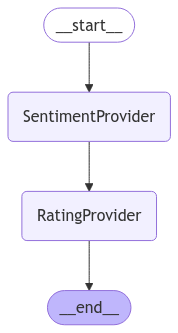

In [73]:
def sentiment_node(state:RatingAndSentimentState):
    ''' This function is responsible for giving the sentiment of the paragraph the user wrote'''
    paragraph = state['paragraph']
    prompt = f'This is the paragraph: {paragraph} and I want you to give the sentiment of it in one word: Positive,Negtaive and Neutral .'
    sentiment = llm.invoke(prompt).content
    return {'sentiment':sentiment}


def rating_node(state:RatingAndSentimentState):
    ''' This function is responsible for giving the rating of the paragraph the user wrote'''
    paragraph = state['paragraph']
    prompt = f'This is the paragraph: {paragraph} and I want you to give the rating of it in 1-10 scale and only return the number not anything else.'
    rating = llm.invoke(prompt).content
    return {'rating':rating}

workflow = StateGraph(RatingAndSentimentState)
workflow.add_node('SentimentProvider',sentiment_node)
workflow.add_node('RatingProvider',rating_node)
workflow.add_edge(START,'SentimentProvider')
workflow.add_edge('SentimentProvider','RatingProvider')
workflow.add_edge('RatingProvider',END)

graph2:CompiledStateGraph = workflow.compile()
display(Image(graph2.get_graph().draw_mermaid_png()))

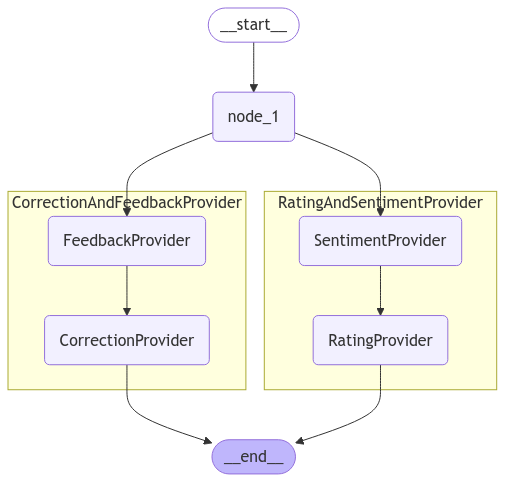

In [74]:
def node_1(state:OverallState) :
    print("Welcome To Node_1")
    pass


qs_builder = StateGraph(OverallState)

qs_builder.add_node('node_1',node_1)
qs_builder.add_node('CorrectionAndFeedbackProvider',builder.compile())
qs_builder.add_node('RatingAndSentimentProvider',workflow.compile())

qs_builder.add_edge(START,'node_1')
qs_builder.add_edge('node_1','CorrectionAndFeedbackProvider')
qs_builder.add_edge('node_1','RatingAndSentimentProvider')
qs_builder.add_edge('CorrectionAndFeedbackProvider',END)
qs_builder.add_edge('RatingAndSentimentProvider',END)

graph:CompiledStateGraph = qs_builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [75]:
graph.invoke({"paragraph": 'Artificial Intelligence is going to change the world in a few couple of years . I saw an article of Gartner in which they were predicting that 2025 will be the biggest year for AI Agents and their definition of AI Agent is that an Autonomous AI System which can take decisions and do actions by their own. And they predicted tht 2030 will be the year of Robotics when these intelligence will come up in their physicaal form and help humans in their daily tasks but many experts including the Noble Laurette Sir Geoffry Hinton think that this evolution can be a or can crete existential crisis for humans  '})

Welcome To Node_1


{'paragraph': 'Artificial Intelligence is going to change the world in a few couple of years . I saw an article of Gartner in which they were predicting that 2025 will be the biggest year for AI Agents and their definition of AI Agent is that an Autonomous AI System which can take decisions and do actions by their own. And they predicted tht 2030 will be the year of Robotics when these intelligence will come up in their physicaal form and help humans in their daily tasks but many experts including the Noble Laurette Sir Geoffry Hinton think that this evolution can be a or can crete existential crisis for humans  Artificial Intelligence is going to change the world in a few couple of years . I saw an article of Gartner in which they were predicting that 2025 will be the biggest year for AI Agents and their definition of AI Agent is that an Autonomous AI System which can take decisions and do actions by their own. And they predicted tht 2030 will be the year of Robotics when these intell